<a href="https://colab.research.google.com/github/Isak-Petrin/distributional_RL_python/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 10000/10000 [00:32<00:00, 306.33it/s]


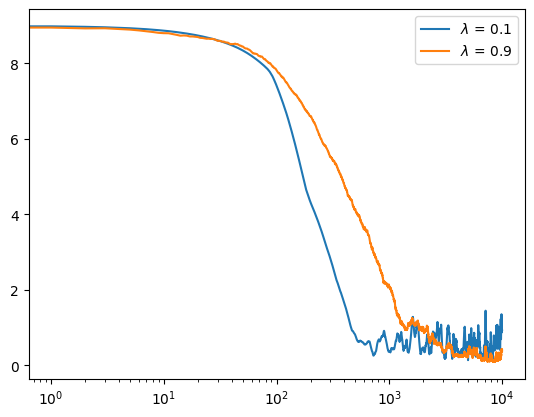

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
class quantile:
    def __init__(self, m: int):
        self.m = m
        self.theta = np.linspace(0,2,self.m)

    def get_theta(self):
        return self.theta
    def set_theta(self,theta):
        self.theta = theta
    def add_theta(self, diff):
        self.theta += diff

class container:
    def __init__(self, x0):
        self.hist = []
        self.xs = [x0]
        self.rs = []
        self.ds = [False]

    def add(self, obs: tuple):
        self.hist.append(obs)
        self.xs.append(obs[0])
        self.rs.append(obs[1])
        self.ds.append(obs[2])

    def get_xs(self):
        return self.xs
    def get_rs(self):
        return self.rs
    def get_x(self,t):
        return self.xs[t]
    def get_d(self,t):
        return self.ds[t]

    def reset(self, x0):
        self.hist = []
        self.xs = [x0]
        self.rs = []
        self.ds = []


class QRTDlAgent:
    def __init__(self, m: int, l: float ,obs_space: int, gamma: float, alpha: float, x0):
        self.m = m
        self.l = l
        self.q = {x: quantile(m = self.m) for x in range(obs_space)}
        self.tau = np.asarray([(2*i - 1) / (2*self.m) for i in range(1,self.m+1)])
        self.gamma = gamma
        self.alpha0 = alpha
        self.container = container(x0=x0)
        self.trace = lambda s: (1 - self.l) * self.l**(s - 1)
        self.t = 0
        self.episode = 0

    def reset(self,x0):
        self.t = 0
        self.container.reset(x0)

    def get_ds(self,t):
        return self.container.get_d(t)

    def get_q(self, x):
        return self.q[x]
    def get_xt(self,t):
        x = self.container.get_x(t = t)
        return x,self.q[x].get_theta()

    def current_alpha(self):
        return np.exp(-self.episode * 1e-3)

    def get_theta(self, x):
        return self.q[x].get_theta()

    def add_diff(self, x, diff):
        self.q[x].add_theta(diff)

    def get_tau(self):
        return self.tau

    def project_monotone(self, x):
        theta = self.q[x].get_theta()
        theta = np.maximum.accumulate(theta)
        self.q[x].set_theta(theta)

    def store(self,x,r, done):
        self.container.add((x,r,done))

    def update(self,x,r,done: bool):
        self.t += 1
        self.store(x,r,done)

        for i in range(self.t):
            h = self.t - i
            target = self.get_target(t = i, h = h)
            x,theta = self.get_xt(t = i)
            trc = self.trace(s = h)
            grad = np.zeros(self.m)
            alpha = self.current_alpha()
            for i in range(self.m):
                for j in range(self.m):
                    grad[i] += (self.alpha0/self.m) * trc * (self.tau[i] - (target[j] < theta[i]))
            self.add_diff(x = x, diff = grad)
            self.project_monotone(x)


    def get_target(self, t,h):
        rs = self.container.get_rs()
        xb = self.container.get_x(t = t+h)
        target = np.zeros(self.m)
        for i,k in enumerate(range(t,t+h)):
            target += self.gamma**i * np.ones(self.m) * rs[k]
            if self.get_ds(t = k) == True:
                return target
        return target + self.get_theta(xb) * self.gamma**h
step = 10000
gamma = 1
s = np.random.normal(size=step) * gamma**3
m = 15
taus = [(2*i - 1) / (2*m) for i in range(1,m+1)]
emp = [np.quantile(s, tau) for tau in taus]


x0 = 0
agent1 = QRTDlAgent(m = 15,obs_space=5,l = .2 ,gamma = 1, alpha = 0.05, x0 = x0)
agent2 = QRTDlAgent(m = 15,obs_space=5,l = .4 ,gamma = 1, alpha = 0.05, x0 = x0)
agent3 = QRTDlAgent(m = 15,obs_space=5,l = .6 ,gamma = 1, alpha = 0.05, x0 = x0)
agent4 = QRTDlAgent(m = 15,obs_space=5,l = .8 ,gamma = 1, alpha = 0.05, x0 = x0)


agent_lst = [agent1, agent2, agent3, agent4]
l_lst = {agent: [] for agent in agent_lst}

for episode in tqdm(range(step)):

    r = np.random.normal()
    obs_lst = [(1,0,False), (2,0,False),(3,0,False),(4,s[episode],True)]

    for obs in obs_lst:
        x,r,done = obs

        for agent in agent_lst:
          agent.update(x = x, r = r, done = done)
          if done == True:
            agent.reset(x0 = x0)
            agent.episode += 1



    est = agent1.get_theta(x = 0)
    u = emp-est
    rho = u * (taus - (u < 0))
    total_loss = np.sum(rho)
    loss_historyTD.append(total_loss)

    est = agent2.get_theta(x = 0)
    u = emp-est
    rho = u * (taus - (u < 0))
    total_loss = np.sum(rho)
    loss_historyMC.append(total_loss)

plt.plot(range(step),loss_historyTD,label = r'$\lambda$ = 0.1')
plt.plot(range(step),loss_historyMC,label = r'$\lambda$ = 0.9')
plt.xscale('log')
plt.legend()
plt.show()